# Import necessary libraries

In [15]:
import os
import random
from inference_sdk import InferenceHTTPClient
import json
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

## Initialize the API pre-trained model from roboflow 

In [16]:
# I used power resources from roboflow cite
# https://universe.roboflow.com/blood-cells-rtipy/bloody-work/model/1
CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="ocXvgLW6tbgWvigfj9hl"
)

## Predict all images, draw boxes, and store results

In [17]:
# Function to get all image paths from the test directory
def get_image_paths(directory):
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.jpg')]

# Function to draw bounding boxes on images
def draw_boxes(image_path, predictions):
    image = cv2.imread(image_path)
    for pred in predictions:
        x = int(pred['x'] - pred['width'] / 2)
        y = int(pred['y'] - pred['height'] / 2)
        width = int(pred['width'])
        height = int(pred['height'])
        confidence = pred['confidence']
        class_name = pred['class']
        
        cv2.rectangle(image, (x, y), (x + width, y + height), (0, 255, 0), 2)
        cv2.putText(image, f"{class_name} ({confidence:.2f})", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return image

In [18]:
# Load COCO annotations
coco_gt = COCO("./images/test/_annotations.coco.json")
image_id_map = {img['file_name']: img['id'] for img in coco_gt.dataset['images']}

test_directory = "./images/test/"
image_paths = get_image_paths(test_directory)
results = []

for image_path in image_paths:
    result = CLIENT.infer(image_path, model_id="bloody-work/1")
    
    # Add image_id to each prediction
    file_name = os.path.basename(image_path)
    image_id = image_id_map[file_name]
    for pred in result['predictions']:
        pred['image_id'] = image_id
        pred['category_id'] = next(cat['id'] for cat in coco_gt.dataset['categories'] if cat['name'] == pred['class'])
        pred['bbox'] = [pred['x'] - pred['width'] / 2, pred['y'] - pred['height'] / 2, pred['width'], pred['height']]
        pred['score'] = pred['confidence']
    
    results.extend(result['predictions'])
    
with open('./output/inference_results.json', 'w') as f:
    json.dump(results, f)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


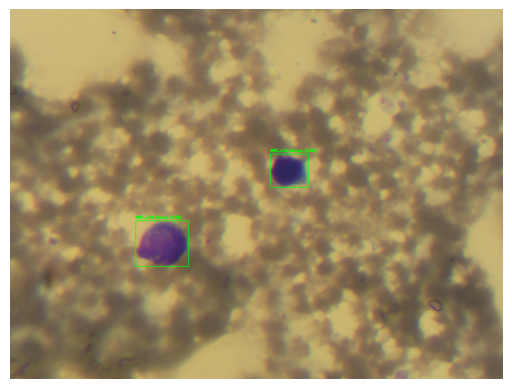

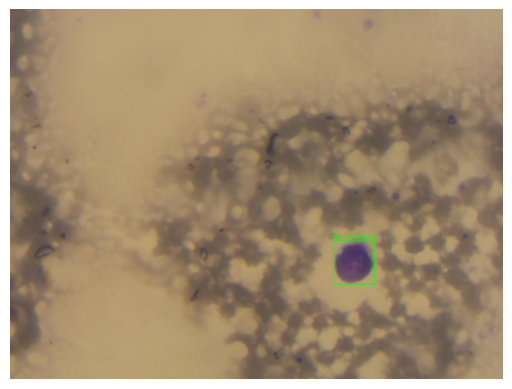

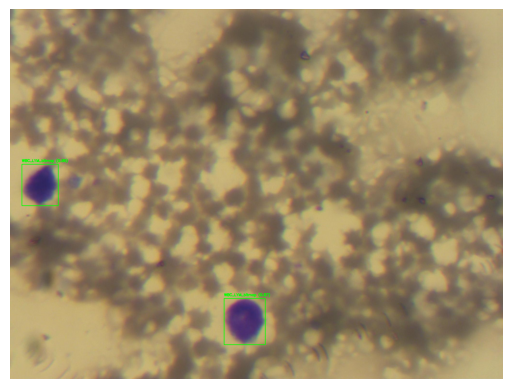

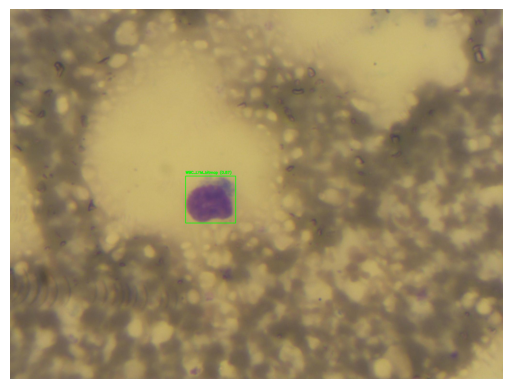

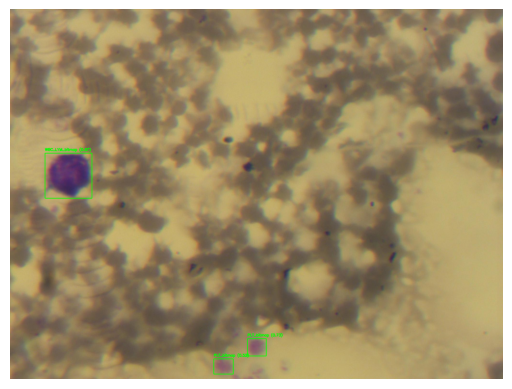

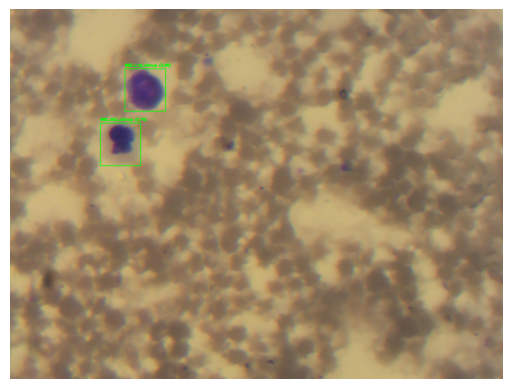

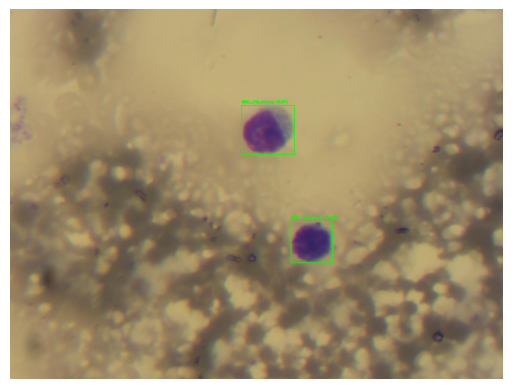

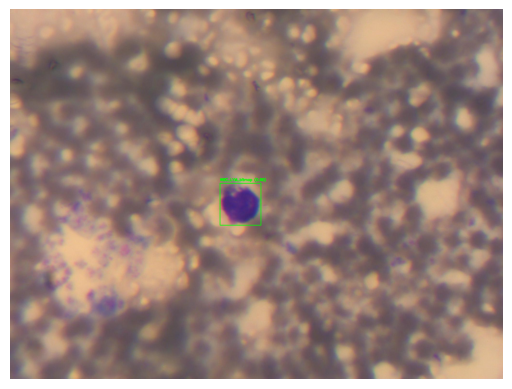

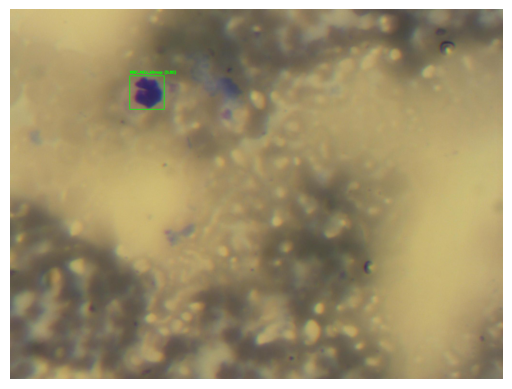

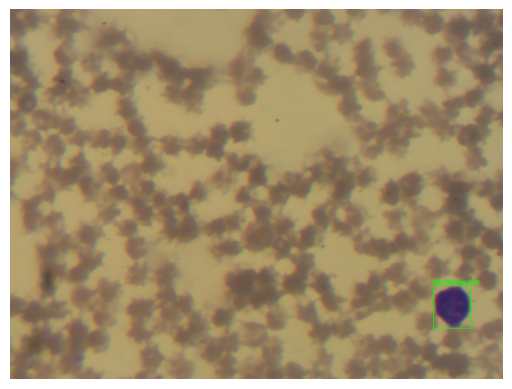

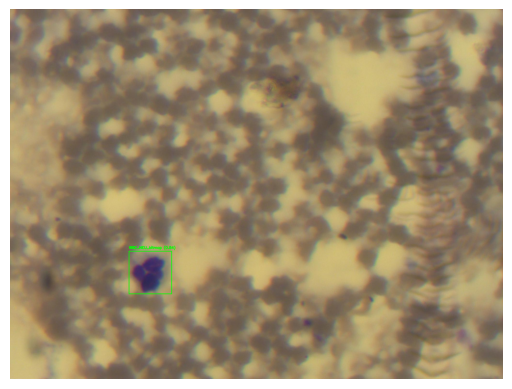

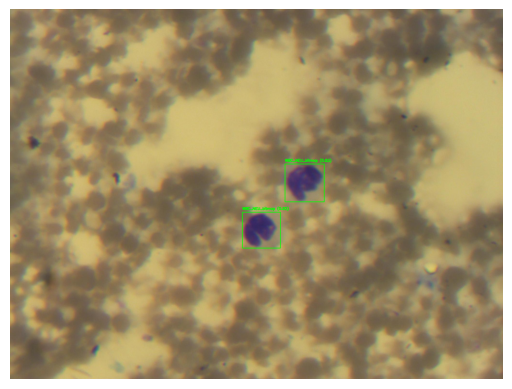

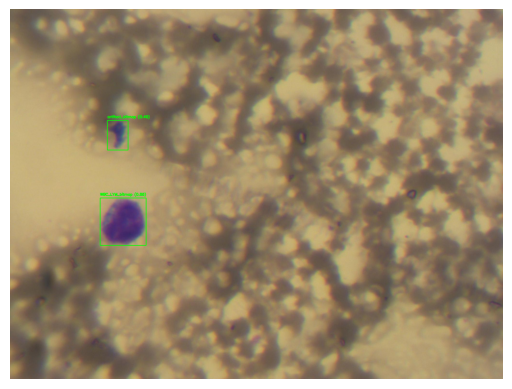

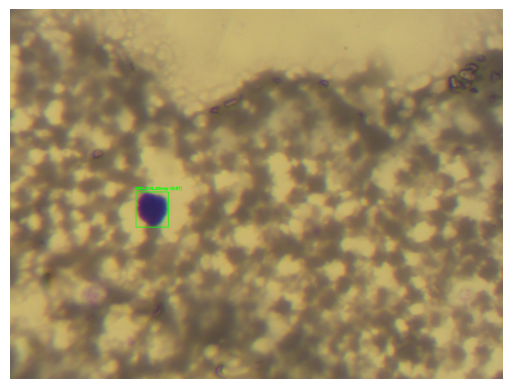

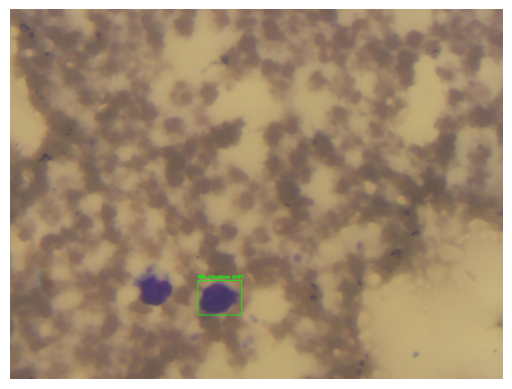

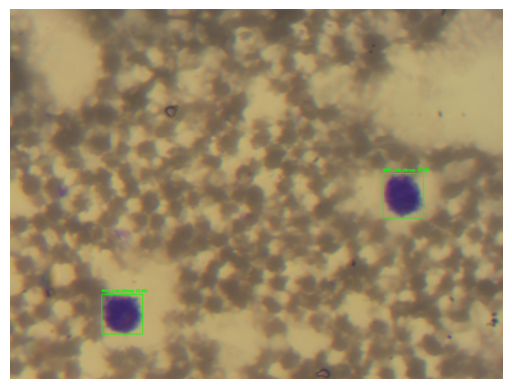

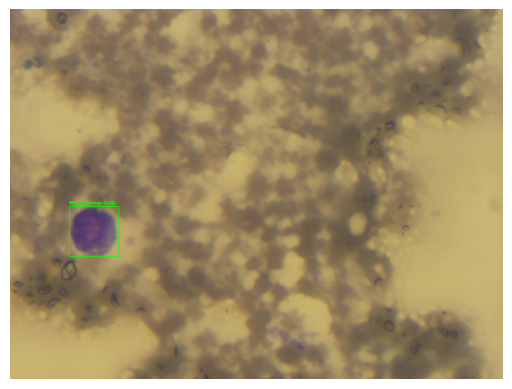

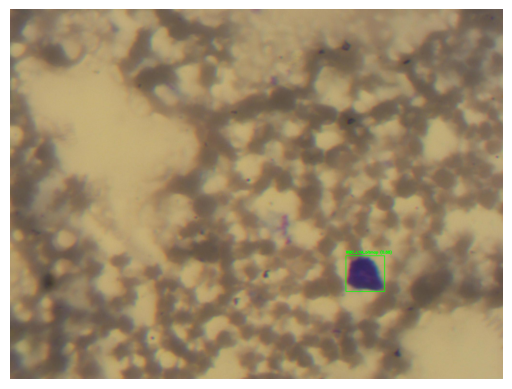

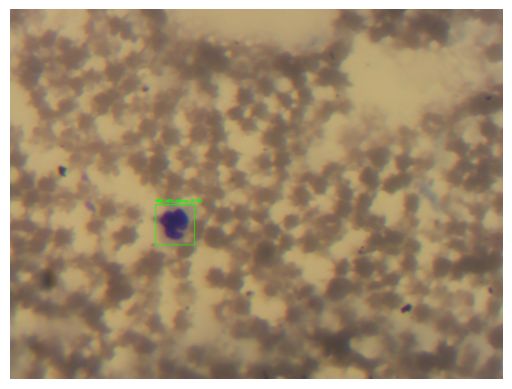

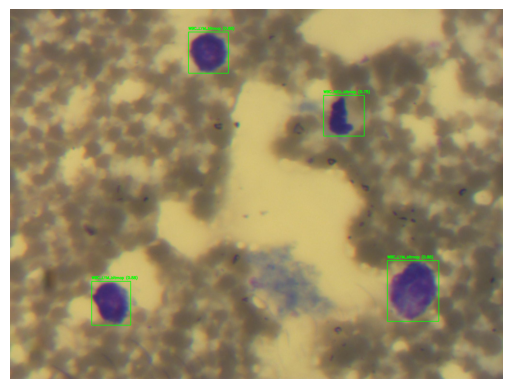

In [19]:
random_image_paths = random.sample(image_paths, 20)

for image_path in random_image_paths:
    result = CLIENT.infer(image_path, model_id="bloody-work/1")
    
    # Draw boxes on the image
    image_with_boxes = draw_boxes(image_path, result['predictions'])
    
    # Display the image with boxes
    plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

## Evaluate models performance

In [5]:
# Load ground truth annotations
coco_gt = COCO("./images/test/_annotations.coco.json")

# Load predictions
coco_dt = coco_gt.loadRes("./output/inference_results.json")

# Initialize COCOeval object
coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.429
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.522
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.489
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.063
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.387
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.454
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Roboflow Test Metrics

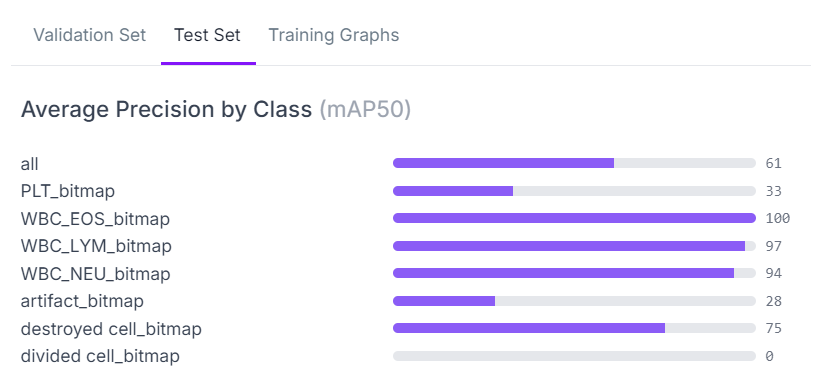

As we can see performance of cloud model look much better than in other model.ipynb file, so we can use differnt models and aproaches to achive our goal. I think both models unification can improve detection and segmentation results.